In [61]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

In [62]:
# Solves quadratic programming problem of type
# minimize 1/2 * x.T * G * x + a.T * x
# subject to C * x >= b
# Pass G - NxN; a - 1xN; C - MxN; b - 1xM
# return - 1xN
def solve_qp(G, a, C, b):
    x0 = np.random.randn(len(G))

    def loss(x, sign=1.):
        return sign * (0.5 * np.dot(x.T, np.dot(G, x)) + np.dot(a, x))

    def jac(x, sign=1.):
        return sign * (np.dot(x.T, G) + a)

    cons = {
        'type': 'ineq',
        'fun': lambda x: np.dot(C, x) - b,
        'jac': lambda x: C
    }

    opt = {'disp': False}

    return scipy.optimize.minimize(
        loss, x0, jac=jac, constraints=cons, method='SLSQP', options=opt).x

In [63]:
def transform_X(X):
    Z = []
    for x in X:
        z = [x[1]**2 - 2 * x[0] - 1, x[0]**2 - 2 * x[1] + 1]
        Z.append(z)
    Z = np.reshape(Z, (-1, 2))
    return Z


def construct_G(Z, Y, kernel):
    G = []
    for i in range(len(Z)):
        g_row = []
        for j in range((len(Z))):
            g_row.append(Y[i][0] * Y[j][0] * kernel(Z[i], Z[j]))
        G.append(g_row)
    G = np.reshape(G, (len(Z), -1))
    return G


def construct_C(Y):
    C = []
    C.append(np.reshape(Y, (1, -1)).tolist()[0])
    C.append(np.negative(C[0]).tolist())
    C = np.append(C, np.eye(len(Y)))
    C = np.reshape(C, (-1, len(Y)))
    return C


def g_x(x, X, Y, alphas, b, kernel):
    sum_ = 0.
    for i in range(len(alphas)):
        if alphas[i] != 0:
            sum_ += Y[i][0] * alphas[i] * kernel(X[i], x)
    return np.sign(sum_ + b)


def recover_b(alphas, X, Y, kernel):
    sum_for_b = 0.
    support_found = False
    support_idx = -1
    for i in range(len(X)):
        if alphas[i] != 0:
            if support_found == False:
                support_found = True
                support_idx = i
            sum_for_b += Y[i][0] * alphas[i] * kernel(X[i], X[support_idx])
    return Y[support_idx][0] - sum_for_b

In [64]:
def plot_data(X, Y):
    for i in range(len(X)):
        if Y[i][0] == 1:
            plt.plot(X[i][0], X[i][1], 'g.')
        elif Y[i][0] == -1:
            plt.plot(X[i][0], X[i][1], 'r.')
    plt.show()

In [147]:
def kernel(x1, x2):
    return (1 + np.dot(x1, np.reshape(x2, (-1, 1))))**2

In [154]:
X = [[1, 0], [0, 1], [0, -1], [-1, 0], [0, 2], [0, -2], [-2, 0]]
Y = [[-1], [-1], [-1], [1], [1], [1], [1]]

G = construct_G(X, Y, kernel)
a = np.ones(len(X))
C = construct_C(Y)
b = np.zeros(len(Y) + 2)

alphas = np.around(solve_qp(G, -a, C, b),5)
print(alphas)
print('Support vectors: ', np.count_nonzero(alphas))

[-0.       0.75087  0.65654  0.88889  0.28284  0.23568 -0.     ]
Support vectors:  5


In [155]:
b = recover_b(alphas, X, Y, kernel)

In [156]:
for x in X:
    print(g_x(x, X, Y, alphas, b, kernel))

[-1.]
[-1.]
[-1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]


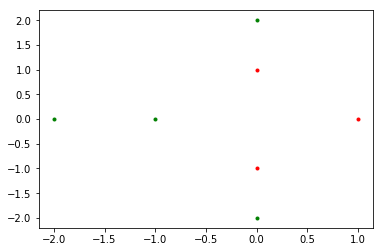

In [94]:
plot_data(X, Y)